# Standard CSP pipelines

This notebook implements multiple standard CSP pipelines and tests their performance on the data from the database provided by [Kaya et al.](https://doi.org/10.1038/sdata.2018.211).
The knowledge and utilities obtained from the experimental notebooks four to five are used throughout this notebook.

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
Baseline correction was done on the first second of the epoch, meaning the second before the visual queue was shown.
The effective training and testing are done on a 2-second window, starting 0.5 seconds before the 1-second visual queue and ending 0.5 seconds after this visual queue.
A window of 2 seconds was chosen as it is a common size for sliding window approaches in online systems.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
- Same subject, same session
   - Same subject, same session: LDA classifier 
   - Same subject, same session: SVM classifier 
   - Same subject, same session: RF classifier 
- Same subject, new session
- New subject
- Cleaning resedual notebook variables

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")
from mne.decoding import CSP

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.svm import SVC

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

MNE version (1.0.2 recommended): 1.0.2
Scikit-learn version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Matplotlib version (3.5.1 recommended): 3.5.1
Pickle version (4.0 recommended): 4.0


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr><hr>

## Same subject, same session

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
We do this for three different traditional machine learning classifiers: linear discriminant analysis (LDA), support vector machines (SVM) and random forest (RF).
K-nearest neighbour (KNN) is not considered as it is too time-consuming in predictions and complex models such as a multilayer perceptron (MLP) are not considered either as they are an integral part of the deep learning models considered in later notebooks.

<hr>

### Same subject, same session: LDA classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [4]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_svm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [5]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6614583333333334 with parameters
{'CSP__n_components': 6, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
17,2.638366,0.048087,0.002499,8.656529e-04,6,svd,0.001,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
15,2.620203,0.050450,0.010247,9.281167e-03,6,svd,0.0001,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
19,2.575015,0.037268,0.003250,4.326721e-04,6,svd,0.00007,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
18,2.600368,0.093760,0.003749,2.486504e-03,6,svd,0.0004,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
31,3.828332,0.061491,0.002750,8.287726e-04,6,lsqr,NaN,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.720486,0.682292,0.689236,0.696181,0.697049,0.014395
32,2.727811,0.112638,0.003249,4.323963e-04,6,eigen,NaN,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.720486,0.682292,0.689236,0.696181,0.697049,0.014395
16,2.634050,0.059822,0.002499,8.656874e-04,6,svd,0.00001,0.578125,0.708333,0.666667,0.692708,0.661458,0.050362,1,0.722222,0.684028,0.689236,0.696181,0.697917,0.014680
29,2.634230,0.069445,0.002499,8.656185e-04,4,lsqr,NaN,0.614583,0.692708,0.671875,0.661458,0.660156,0.028616,8,0.697917,0.666667,0.694444,0.684028,0.685764,0.012153
10,2.596897,0.081477,0.002000,1.685874e-07,4,svd,0.0001,0.614583,0.692708,0.671875,0.661458,0.660156,0.028616,8,0.699653,0.666667,0.694444,0.684028,0.686198,0.012602
11,2.542957,0.050572,0.001500,4.998446e-04,4,svd,0.00001,0.614583,0.692708,0.671875,0.661458,0.660156,0.028616,8,0.699653,0.666667,0.694444,0.684028,0.686198,0.012602




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
22,2.560733,0.046330,0.006748,0.004814,10,svd,0.001,0.598958,0.656250,0.671875,0.651042,0.644531,0.027406,24,0.729167,0.750000,0.715278,0.718750,0.728299,0.013532
23,2.698398,0.044207,0.003499,0.000500,10,svd,0.0004,0.598958,0.656250,0.671875,0.651042,0.644531,0.027406,24,0.729167,0.750000,0.715278,0.718750,0.728299,0.013532
24,2.619778,0.046420,0.005000,0.003464,10,svd,0.00007,0.598958,0.656250,0.671875,0.651042,0.644531,0.027406,24,0.729167,0.750000,0.715278,0.718750,0.728299,0.013532
1,2.690685,0.016161,0.002749,0.001920,2,svd,0.00001,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
2,3.448836,0.068553,0.001750,0.000433,2,svd,0.001,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
26,2.667278,0.062282,0.002250,0.000433,2,eigen,NaN,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
4,2.847526,0.058999,0.001750,0.000432,2,svd,0.00007,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
25,2.632682,0.062124,0.001750,0.000433,2,lsqr,NaN,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
3,2.971258,0.054610,0.001750,0.000829,2,svd,0.0004,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897
0,2.860130,0.053891,0.002000,0.001224,2,svd,0.0001,0.609375,0.505208,0.526042,0.651042,0.572917,0.059612,29,0.664931,0.522569,0.541667,0.661458,0.597656,0.065897




In total there are 35 different configurations tested.
The best mean test score is 0.6615
There are 7 configurations with this maximum score
There are 28 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,28.000000,28.000000,28.000000,2.800000e+01,28.0,28,20.000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000,28.000000
unique,NaN,NaN,NaN,NaN,4.0,3,5.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,6.0,svd,0.001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,20,4.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.661364,0.060151,0.003457,1.805770e-03,NaN,NaN,NaN,0.595424,0.685268,0.664435,0.667969,0.653274,0.035462,12.071429,0.706225,0.691716,0.694134,0.690538,0.695654,0.011574
std,0.236873,0.020000,0.002313,2.365813e-03,NaN,NaN,NaN,0.013600,0.018775,0.011289,0.015633,0.007722,0.009210,8.519818,0.021296,0.034980,0.014254,0.020480,0.021547,0.003480
min,2.469499,0.022866,0.001500,1.685874e-07,NaN,NaN,NaN,0.578125,0.656250,0.645833,0.651042,0.644531,0.027406,1.000000,0.675347,0.666667,0.677083,0.663194,0.670573,0.005807
25%,2.584624,0.046398,0.001937,4.996064e-04,NaN,NaN,NaN,0.585938,0.677083,0.661458,0.658854,0.645833,0.028616,6.250000,0.692274,0.666667,0.686198,0.678819,0.681966,0.010566
50%,2.611223,0.058192,0.002999,8.656357e-04,NaN,NaN,NaN,0.596354,0.687500,0.669271,0.664062,0.653646,0.031372,11.500000,0.710069,0.674479,0.691840,0.690104,0.691623,0.012869
75%,2.674828,0.068168,0.003811,2.166935e-03,NaN,NaN,NaN,0.602865,0.696615,0.671875,0.673177,0.660482,0.039228,19.000000,0.723524,0.700521,0.699653,0.701823,0.705512,0.013748





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7144415357766144 with parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
34,2.915794,0.092838,0.003749,0.000829,10,eigen,NaN,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.753043,0.756944,0.750106,0.019726
24,2.820352,0.114471,0.010747,0.012271,10,svd,0.00007,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
23,2.757913,0.079570,0.013246,0.017748,10,svd,0.0004,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
22,2.836415,0.134609,0.004249,0.000829,10,svd,0.001,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
21,2.743798,0.063981,0.004749,0.001920,10,svd,0.00001,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
20,2.835930,0.074028,0.004249,0.000433,10,svd,0.0001,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.751304,0.756944,0.749671,0.019676
33,2.963102,0.101336,0.003749,0.000828,10,lsqr,NaN,0.755208,0.671875,0.739583,0.691099,0.714442,0.034098,1,0.772174,0.718261,0.753043,0.756944,0.750106,0.019726
19,2.729544,0.103255,0.002250,0.000433,6,svd,0.00007,0.744792,0.656250,0.703125,0.732984,0.709288,0.034180,8,0.766957,0.711304,0.749565,0.744792,0.743154,0.020154
18,2.758624,0.100434,0.002749,0.000829,6,svd,0.0004,0.744792,0.656250,0.703125,0.732984,0.709288,0.034180,8,0.766957,0.711304,0.749565,0.744792,0.743154,0.020154
16,2.737050,0.137008,0.002250,0.000432,6,svd,0.00001,0.744792,0.656250,0.703125,0.732984,0.709288,0.034180,8,0.766957,0.711304,0.749565,0.744792,0.743154,0.020154




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
5,2.657662,0.055349,0.001500,0.000499,3,svd,0.0001,0.364583,0.500000,0.390625,0.397906,0.413279,0.051578,22,0.384348,0.457391,0.420870,0.409722,0.418083,0.026272
28,2.869725,0.119720,0.001499,0.000500,3,eigen,NaN,0.364583,0.500000,0.390625,0.397906,0.413279,0.051578,22,0.382609,0.457391,0.420870,0.409722,0.417648,0.026835
27,2.874114,0.081583,0.001749,0.000433,3,lsqr,NaN,0.364583,0.500000,0.390625,0.397906,0.413279,0.051578,22,0.382609,0.457391,0.420870,0.409722,0.417648,0.026835
2,2.873989,0.139466,0.001749,0.000433,2,svd,0.001,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.353043,0.373913,0.424348,0.401042,0.388087,0.026980
25,2.965988,0.100436,0.001750,0.000432,2,lsqr,NaN,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.351304,0.373913,0.424348,0.399306,0.387218,0.027348
1,3.268848,0.095755,0.001999,0.000707,2,svd,0.00001,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.353043,0.373913,0.424348,0.401042,0.388087,0.026980
3,2.706552,0.076533,0.004249,0.004491,2,svd,0.0004,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.353043,0.373913,0.424348,0.401042,0.388087,0.026980
4,2.616163,0.072099,0.001750,0.000432,2,svd,0.00007,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.353043,0.373913,0.424348,0.401042,0.388087,0.026980
26,2.815629,0.050155,0.002249,0.000432,2,eigen,NaN,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.351304,0.373913,0.424348,0.399306,0.387218,0.027348
0,3.246334,0.148674,0.001500,0.000499,2,svd,0.0001,0.364583,0.416667,0.385417,0.387435,0.388525,0.018547,29,0.353043,0.373913,0.424348,0.401042,0.388087,0.026980




In total there are 35 different configurations tested.
The best mean test score is 0.7144
There are 7 configurations with this maximum score
There are 14 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,14.000000,14.000000,14.000000,1.400000e+01,14.0,14,10.00000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
unique,NaN,NaN,NaN,NaN,2.0,3,5.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.00007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,10,2.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.823481,0.099315,0.004602,2.855871e-03,NaN,NaN,NaN,0.750000,0.664062,0.720610,0.712042,0.711679,0.034183,5.214286,0.769565,0.714783,0.750683,0.750868,0.746475,0.019922
std,0.101448,0.025941,0.003257,5.290822e-03,NaN,NaN,NaN,0.005405,0.008107,0.019765,0.021733,0.002900,0.000135,4.676925,0.002707,0.003610,0.001296,0.006306,0.003449,0.000241
min,2.729544,0.051201,0.002250,6.529362e-07,NaN,NaN,NaN,0.744792,0.656250,0.697917,0.691099,0.707986,0.034098,1.000000,0.766957,0.711304,0.749565,0.744792,0.743154,0.019676
25%,2.747327,0.082550,0.002907,4.614444e-04,NaN,NaN,NaN,0.744792,0.656250,0.703125,0.691099,0.709288,0.034098,1.000000,0.766957,0.711304,0.749565,0.744792,0.743154,0.019676
50%,2.798684,0.100885,0.003658,8.283594e-04,NaN,NaN,NaN,0.750000,0.664062,0.721354,0.712042,0.711865,0.034139,4.500000,0.769565,0.714783,0.750435,0.750868,0.746413,0.019940
75%,2.846303,0.119871,0.004249,1.647068e-03,NaN,NaN,NaN,0.755208,0.671875,0.739583,0.732984,0.714442,0.034180,8.000000,0.772174,0.718261,0.751304,0.756944,0.749671,0.020154





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7342931937172774 with parameters
{'CSP__n_components': 10, 'LDA__solver': 'svd', 'LDA__tol': 0.0001}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
34,2.668360,0.090464,0.003749,8.288804e-04,10,eigen,NaN,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.787086,0.783595,0.736475,0.790576,0.774433,0.022054
24,2.820031,0.079210,0.005749,2.585159e-03,10,svd,0.00007,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.785340,0.783595,0.736475,0.790576,0.773997,0.021815
23,2.924817,0.073776,0.003749,4.327406e-04,10,svd,0.0004,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.785340,0.783595,0.736475,0.790576,0.773997,0.021815
22,2.975696,0.111334,0.003000,2.384186e-07,10,svd,0.001,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.785340,0.783595,0.736475,0.790576,0.773997,0.021815
21,3.052873,0.155479,0.003500,8.659283e-04,10,svd,0.00001,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.785340,0.783595,0.736475,0.790576,0.773997,0.021815
20,2.979868,0.068541,0.007247,6.829423e-03,10,svd,0.0001,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.785340,0.783595,0.736475,0.790576,0.773997,0.021815
33,2.914200,0.060271,0.007511,7.238833e-03,10,lsqr,NaN,0.706806,0.738220,0.738220,0.753927,0.734293,0.017116,1,0.787086,0.783595,0.736475,0.790576,0.774433,0.022054
32,2.955932,0.153432,0.002499,4.995468e-04,6,eigen,NaN,0.691099,0.722513,0.722513,0.664921,0.700262,0.024099,8,0.731239,0.706806,0.734729,0.741710,0.728621,0.013147
31,2.883022,0.129580,0.003499,5.000235e-04,6,lsqr,NaN,0.691099,0.722513,0.722513,0.664921,0.700262,0.024099,8,0.731239,0.706806,0.734729,0.741710,0.728621,0.013147
19,2.939181,0.091919,0.007998,9.243115e-03,6,svd,0.00007,0.691099,0.722513,0.722513,0.664921,0.700262,0.024099,8,0.731239,0.706806,0.736475,0.741710,0.729058,0.013370




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
5,3.101356,0.078158,0.001251,0.000432,3,svd,0.0001,0.659686,0.612565,0.586387,0.649215,0.626963,0.029239,22,0.670157,0.626527,0.638743,0.687609,0.655759,0.024320
27,2.789545,0.113972,0.001999,0.000707,3,lsqr,NaN,0.659686,0.612565,0.586387,0.649215,0.626963,0.029239,22,0.670157,0.626527,0.638743,0.687609,0.655759,0.024320
28,2.864160,0.086134,0.001749,0.000829,3,eigen,NaN,0.659686,0.612565,0.586387,0.649215,0.626963,0.029239,22,0.670157,0.626527,0.638743,0.687609,0.655759,0.024320
1,3.146745,0.082234,0.002250,0.000433,2,svd,0.00001,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.596859,0.575916,0.635253,0.595113,0.024987
2,3.118679,0.088869,0.001500,0.000866,2,svd,0.001,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.596859,0.575916,0.635253,0.595113,0.024987
3,3.020644,0.161201,0.001499,0.000500,2,svd,0.0004,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.596859,0.575916,0.635253,0.595113,0.024987
25,2.802779,0.112232,0.001250,0.000433,2,lsqr,NaN,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.598604,0.575916,0.635253,0.595550,0.025029
4,2.984879,0.066979,0.001750,0.000432,2,svd,0.00007,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.596859,0.575916,0.635253,0.595113,0.024987
26,2.794722,0.149503,0.001999,0.000707,2,eigen,NaN,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.598604,0.575916,0.635253,0.595550,0.025029
0,3.167731,0.150488,0.001999,0.000707,2,svd,0.0001,0.638743,0.534031,0.544503,0.602094,0.579843,0.042755,29,0.572426,0.596859,0.575916,0.635253,0.595113,0.024987




In total there are 35 different configurations tested.
The best mean test score is 0.7343
There are 7 configurations with this maximum score
There are 7 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_LDA__solver,param_LDA__tol,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,7.000000,7.000000,7.000000,7.000000e+00,7.0,7,5.00000,7.000000,7.000000e+00,7.000000e+00,7.000000,7.000000e+00,7.000000e+00,7.0,7.000000,7.000000e+00,7.000000e+00,7.000000e+00,7.000000,7.000000
unique,NaN,NaN,NaN,NaN,1.0,3,5.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,svd,0.00007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,7.0,5,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.905121,0.091296,0.004929,2.683029e-03,NaN,NaN,NaN,0.706806,7.382199e-01,7.382199e-01,0.753927,7.342932e-01,1.711610e-02,1.0,0.785839,7.835951e-01,7.364747e-01,7.905759e-01,0.774121,0.021883
std,0.126600,0.032800,0.001882,3.081082e-03,NaN,NaN,NaN,0.000000,1.199178e-16,1.199178e-16,0.000000,1.199178e-16,3.747431e-18,0.0,0.000852,1.199178e-16,1.199178e-16,1.199178e-16,0.000213,0.000116
min,2.668360,0.060271,0.003000,2.384186e-07,NaN,NaN,NaN,0.706806,7.382199e-01,7.382199e-01,0.753927,7.342932e-01,1.711610e-02,1.0,0.785340,7.835951e-01,7.364747e-01,7.905759e-01,0.773997,0.021815
25%,2.867116,0.071159,0.003625,6.308105e-04,NaN,NaN,NaN,0.706806,7.382199e-01,7.382199e-01,0.753927,7.342932e-01,1.711610e-02,1.0,0.785340,7.835951e-01,7.364747e-01,7.905759e-01,0.773997,0.021815
50%,2.924817,0.079210,0.003749,8.659283e-04,NaN,NaN,NaN,0.706806,7.382199e-01,7.382199e-01,0.753927,7.342932e-01,1.711610e-02,1.0,0.785340,7.835951e-01,7.364747e-01,7.905759e-01,0.773997,0.021815
75%,2.977782,0.100899,0.006498,4.707291e-03,NaN,NaN,NaN,0.706806,7.382199e-01,7.382199e-01,0.753927,7.342932e-01,1.711610e-02,1.0,0.786213,7.835951e-01,7.364747e-01,7.905759e-01,0.774215,0.021934





####################################################
# TEST RESULTS FOR SUBJECT B
####################################################



Test accuracy for subject B: 0.609375


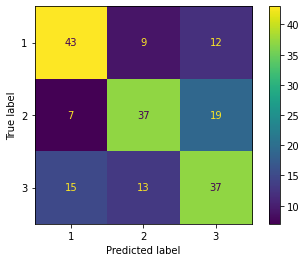

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...


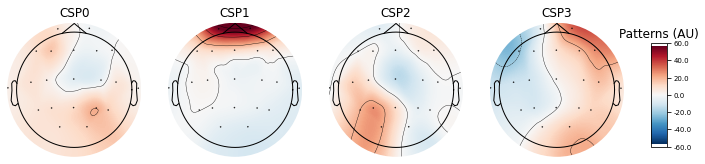




####################################################
# TEST RESULTS FOR SUBJECT C
####################################################



Test accuracy for subject C: 0.7239583333333334


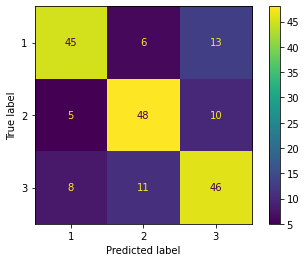

Reading 0 ... 669399  =      0.000 ...  3346.995 secs...


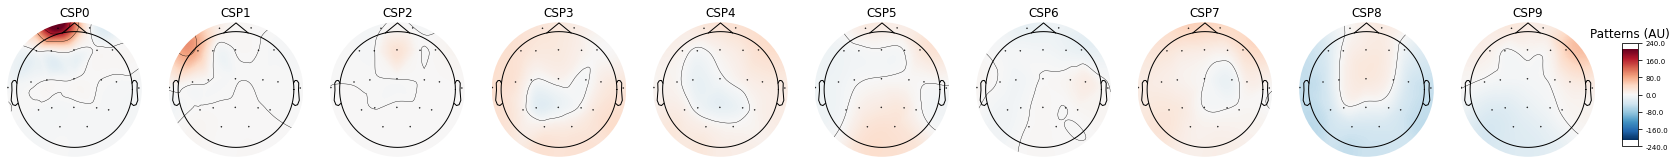




####################################################
# TEST RESULTS FOR SUBJECT E
####################################################



Test accuracy for subject E: 0.7277486910994765


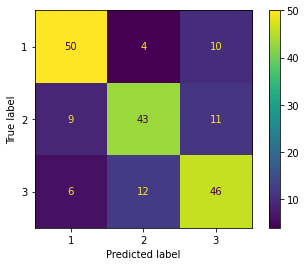

Reading 0 ... 666999  =      0.000 ...  3334.995 secs...


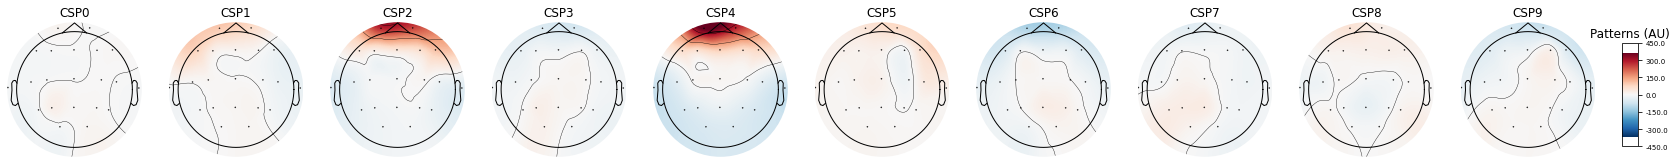

In [6]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_csplda_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: SVM classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> SVM
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For SVM:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [7]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = True # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                svm = SVC()
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('SVM', svm)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['rbf', 'sigmoid'],
                        "SVM__gamma":['scale', 'auto', 10, 1, 0.1, 0.01, 0.001]}
                              ,{
                        "CSP__n_components": [4, 6, 10],
                        "SVM__C": [0.01, 0.1, 1, 10, 100],
                        "SVM__kernel": ['linear']}]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_cspsvm_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del svm
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

Reading 0 ... 667799  =      0.000 ...  3338.995 secs...
Using data from preloaded Raw for 960 events and 601 original time points ...
0 bad epochs dropped
Fitting 4 folds for each of 225 candidates, totalling 900 fits
Reading 0 ... 669399  =      0.000 ...  3346.995 secs...
Using data from preloaded Raw for 959 events and 601 original time points ...
0 bad epochs dropped
Fitting 4 folds for each of 225 candidates, totalling 900 fits
Reading 0 ... 666999  =      0.000 ...  3334.995 secs...
Using data from preloaded Raw for 955 events and 601 original time points ...
0 bad epochs dropped
Fitting 4 folds for each of 225 candidates, totalling 900 fits


#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                                |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------------|
| B           | 0.6693 +- 0.02981                        | xxx                                | 4 CSP components \| SVM RBF with C 0.1 and Gamma auto     |
| C           | 0.7262 +- 0.0298                         | xxx                                | 6 CSP components \| SVM RBF with C 100 and Gamma 0.001    |
| E           | 0.7356 +- 0.0159                         | xxx                                | 6 CSP components \| SVM sigmoid with C 100 and Gamma 0.01 |

In [8]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_cspsvm_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id




####################################################
# GRID SEARCH RESULTS FOR SUBJECT B
####################################################



Best estimator has accuracy of 0.6692708333333334 with parameters
{'CSP__n_components': 4, 'SVM__C': 0.1, 'SVM__gamma': 'auto', 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
16,2.062838,0.029235,0.010996,4.878850e-07,4,0.1,auto,rbf,0.630208,0.713542,...,0.661458,0.669271,0.029806,1,0.696181,0.673611,0.677083,0.699653,0.686632,0.011417
52,2.095329,0.047012,0.010246,8.289531e-04,4,10,0.01,rbf,0.635417,0.692708,...,0.651042,0.667969,0.025349,2,0.697917,0.668403,0.689236,0.694444,0.687500,0.011450
50,2.056091,0.033294,0.008747,4.331534e-04,4,10,0.1,rbf,0.630208,0.682292,...,0.677083,0.667969,0.021904,2,0.713542,0.694444,0.689236,0.701389,0.699653,0.009104
212,2.063338,0.040255,0.002749,4.330503e-04,4,1,NaN,linear,0.625000,0.697917,...,0.661458,0.666667,0.027313,4,0.703125,0.668403,0.682292,0.689236,0.685764,0.012519
36,2.077584,0.031576,0.009497,4.999638e-04,4,1,0.1,rbf,0.614583,0.687500,...,0.666667,0.665365,0.030895,5,0.704861,0.678819,0.682292,0.697917,0.690972,0.010772
53,2.071336,0.031652,0.003748,4.328437e-04,4,10,0.01,sigmoid,0.630208,0.697917,...,0.645833,0.665365,0.028138,5,0.704861,0.668403,0.678819,0.699653,0.687934,0.014903
69,2.080583,0.027161,0.004249,4.327411e-04,4,100,0.001,sigmoid,0.630208,0.697917,...,0.645833,0.665365,0.028138,5,0.704861,0.668403,0.678819,0.699653,0.687934,0.014903
68,2.096828,0.064931,0.009498,8.665823e-04,4,100,0.001,rbf,0.630208,0.692708,...,0.651042,0.665365,0.025878,5,0.694444,0.663194,0.680556,0.696181,0.683594,0.013243
67,2.056341,0.028035,0.003748,4.323968e-04,4,100,0.01,sigmoid,0.625000,0.692708,...,0.661458,0.665365,0.025878,5,0.703125,0.668403,0.684028,0.687500,0.685764,0.012337
66,2.057090,0.030234,0.009748,1.298875e-03,4,100,0.01,rbf,0.625000,0.692708,...,0.666667,0.665365,0.025080,5,0.704861,0.678819,0.668403,0.689236,0.685330,0.013469




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
89,2.061839,0.017805,0.007498,5.000853e-04,6,0.1,10,sigmoid,0.380208,0.416667,...,0.406250,0.404948,0.014903,216,0.442708,0.390625,0.388889,0.369792,0.398003,0.027074
33,2.057590,0.031457,0.005248,4.327061e-04,4,1,10,sigmoid,0.338542,0.520833,...,0.338542,0.399740,0.074424,217,0.394097,0.442708,0.342014,0.322917,0.375434,0.046768
47,2.070586,0.019985,0.005498,4.995478e-04,4,10,10,sigmoid,0.364583,0.510417,...,0.307292,0.398438,0.074435,218,0.397569,0.444444,0.362847,0.314236,0.379774,0.047646
61,2.058839,0.027923,0.005249,4.335321e-04,4,100,10,sigmoid,0.359375,0.510417,...,0.302083,0.393229,0.076236,219,0.397569,0.446181,0.348958,0.324653,0.379340,0.046674
74,2.081832,0.023893,0.012996,2.920019e-07,6,0.01,10,rbf,0.453125,0.401042,...,0.338542,0.381510,0.049187,220,0.663194,0.664931,0.338542,0.336806,0.500868,0.163197
88,2.069335,0.032868,0.013995,1.731340e-03,6,0.1,10,rbf,0.453125,0.401042,...,0.338542,0.381510,0.049187,220,0.663194,0.664931,0.338542,0.336806,0.500868,0.163197
19,2.069086,0.035467,0.006498,4.997254e-04,4,0.1,10,sigmoid,0.359375,0.380208,...,0.369792,0.380208,0.019488,222,0.385417,0.388889,0.413194,0.342014,0.382378,0.025644
172,2.081583,0.039720,0.015496,8.666903e-04,10,1,10,rbf,0.421875,0.390625,...,0.333333,0.376302,0.033222,223,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
144,2.066337,0.038231,0.015496,8.663757e-04,10,0.01,10,rbf,0.333333,0.343750,...,0.338542,0.337240,0.004319,224,0.673611,0.673611,0.338542,0.336806,0.505642,0.167970
158,2.077584,0.039322,0.014996,7.078143e-04,10,0.1,10,rbf,0.333333,0.343750,...,0.338542,0.337240,0.004319,224,0.673611,0.673611,0.338542,0.336806,0.505642,0.167970




In total there are 225 different configurations tested.
The best mean test score is 0.6693
There are 1 configurations with this maximum score
There are 41 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,41.000000,41.000000,41.000000,4.100000e+01,41.0,41.0,35.00,41,41.000000,41.000000,...,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000,41.000000
unique,NaN,NaN,NaN,NaN,2.0,5.0,6.00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,4.0,0.1,0.01,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,30.0,12.0,9.00,23,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.066697,0.033610,0.007784,6.481829e-04,NaN,NaN,NaN,NaN,0.616489,0.696519,...,0.657393,0.659966,0.030955,19.756098,0.709646,0.681741,0.684282,0.697282,0.693238,0.012254
std,0.012887,0.008334,0.003400,4.352666e-04,NaN,NaN,NaN,NaN,0.014720,0.013022,...,0.015341,0.005172,0.007044,12.287759,0.013757,0.013606,0.014161,0.010054,0.011620,0.002768
min,2.049093,0.017749,0.002749,3.097148e-07,NaN,NaN,NaN,NaN,0.588542,0.677083,...,0.630208,0.649740,0.017806,1.000000,0.673611,0.661458,0.659722,0.663194,0.664931,0.004490
25%,2.056590,0.028129,0.004250,4.328437e-04,NaN,NaN,NaN,NaN,0.604167,0.687500,...,0.645833,0.656250,0.025878,5.000000,0.699653,0.671875,0.677083,0.689236,0.685764,0.011142
50%,2.062839,0.032509,0.008997,4.341517e-04,NaN,NaN,NaN,NaN,0.619792,0.692708,...,0.656250,0.660156,0.029232,21.000000,0.704861,0.678819,0.682292,0.697917,0.690538,0.012905
75%,2.073335,0.038211,0.010497,8.289704e-04,NaN,NaN,NaN,NaN,0.630208,0.697917,...,0.671875,0.665365,0.036644,27.000000,0.723958,0.687500,0.690972,0.703125,0.700087,0.014178





####################################################
# GRID SEARCH RESULTS FOR SUBJECT C
####################################################



Best estimator has accuracy of 0.7262284576788831 with parameters
{'CSP__n_components': 6, 'SVM__C': 100, 'SVM__gamma': 0.001, 'SVM__kernel': 'rbf'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
138,2.138314,0.064616,0.009747,4.325340e-04,6,100,0.001,rbf,0.755208,0.677083,...,0.743455,0.726228,0.029835,1,0.760000,0.725217,0.760000,0.756944,0.750540,0.014673
122,2.131567,0.064912,0.009497,4.990702e-04,6,10,0.01,rbf,0.729167,0.677083,...,0.748691,0.721027,0.026593,2,0.760000,0.732174,0.766957,0.756944,0.754019,0.013124
123,2.122069,0.059648,0.004749,4.328783e-04,6,10,0.01,sigmoid,0.760417,0.677083,...,0.738220,0.721013,0.031382,3,0.756522,0.716522,0.760000,0.758681,0.747931,0.018177
216,2.111574,0.054261,0.003998,5.196212e-07,6,0.1,NaN,linear,0.755208,0.671875,...,0.743455,0.719718,0.032564,4,0.754783,0.718261,0.760000,0.758681,0.747931,0.017237
139,2.113572,0.055252,0.004498,4.998447e-04,6,100,0.001,sigmoid,0.755208,0.671875,...,0.743455,0.719718,0.032564,4,0.753043,0.718261,0.760000,0.758681,0.747496,0.017080
98,2.128318,0.054933,0.009747,4.328781e-04,6,1,scale,rbf,0.739583,0.677083,...,0.743455,0.717114,0.026825,6,0.765217,0.739130,0.761739,0.751736,0.754456,0.010138
217,2.111574,0.063782,0.004248,8.283779e-04,6,1,NaN,linear,0.760417,0.661458,...,0.738220,0.717107,0.037065,7,0.758261,0.725217,0.763478,0.753472,0.750107,0.014799
219,2.198046,0.064861,0.003749,4.330502e-04,6,100,NaN,linear,0.760417,0.656250,...,0.738220,0.717107,0.038852,8,0.761739,0.723478,0.763478,0.750000,0.749674,0.015988
218,2.132316,0.058110,0.004499,8.661691e-04,6,10,NaN,linear,0.765625,0.651042,...,0.738220,0.717107,0.042359,8,0.763478,0.725217,0.763478,0.750000,0.750543,0.015623
106,2.116072,0.060513,0.009747,4.333615e-04,6,1,0.1,rbf,0.744792,0.677083,...,0.743455,0.715812,0.029258,10,0.772174,0.735652,0.763478,0.755208,0.756628,0.013515




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
27,2.124819,0.061106,0.004998,4.256623e-07,4,0.1,0.001,sigmoid,0.338542,0.338542,...,0.335079,0.337676,0.001500,167,0.337391,0.337391,0.337391,0.338542,0.337679,0.000498
159,2.140564,0.064930,0.006498,5.003216e-04,10,0.1,10,sigmoid,0.343750,0.338542,...,0.329843,0.337669,0.004994,217,0.339130,0.358261,0.342609,0.342014,0.345503,0.007482
161,2.137314,0.051184,0.008997,7.068027e-04,10,0.1,1,sigmoid,0.343750,0.338542,...,0.329843,0.337669,0.004994,217,0.339130,0.354783,0.342609,0.343750,0.345068,0.005861
45,2.121568,0.065900,0.005248,4.331191e-04,4,10,auto,sigmoid,0.343750,0.328125,...,0.298429,0.337628,0.029485,219,0.326957,0.354783,0.422609,0.338542,0.360722,0.037072
119,2.129568,0.057568,0.006748,4.330502e-04,6,10,1,sigmoid,0.307292,0.385417,...,0.314136,0.333742,0.030765,220,0.335652,0.403478,0.323478,0.322917,0.346381,0.033355
31,2.132565,0.057902,0.006498,4.998448e-04,4,1,auto,sigmoid,0.348958,0.317708,...,0.335079,0.332468,0.011352,221,0.349565,0.361739,0.353043,0.312500,0.344212,0.018838
59,2.109323,0.052323,0.007248,2.277293e-03,4,100,auto,sigmoid,0.322917,0.322917,...,0.303665,0.331125,0.026523,222,0.326957,0.354783,0.427826,0.335069,0.361159,0.039798
63,2.112073,0.054514,0.006248,1.089496e-03,4,100,1,sigmoid,0.302083,0.369792,...,0.319372,0.328541,0.025087,223,0.321739,0.373913,0.293913,0.315972,0.326384,0.029340
49,2.113823,0.061155,0.006248,4.327061e-04,4,10,1,sigmoid,0.276042,0.375000,...,0.314136,0.315513,0.036898,224,0.304348,0.379130,0.325217,0.312500,0.330299,0.029157
175,2.128068,0.052904,0.009247,8.287548e-04,10,1,1,sigmoid,0.375000,0.270833,...,0.308901,0.303788,0.044901,225,0.360000,0.269565,0.335652,0.343750,0.327242,0.034435




In total there are 225 different configurations tested.
The best mean test score is 0.7262
There are 1 configurations with this maximum score
There are 27 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,27.000000,27.000000,27.000000,2.700000e+01,27.0,27.0,20.00,27,27.000000,27.000000,...,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000,27.000000
unique,NaN,NaN,NaN,NaN,2.0,5.0,5.00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,6.0,10.0,0.01,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,19.0,8.0,7.00,14,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.138231,0.060986,0.008192,6.971704e-04,NaN,NaN,NaN,NaN,0.747492,0.662230,...,0.723483,0.713375,0.033656,13.814815,0.761031,0.734364,0.759549,0.753344,0.752072,0.011619
std,0.037548,0.005814,0.003710,5.522133e-04,NaN,NaN,NaN,NaN,0.010651,0.011798,...,0.019538,0.005212,0.005763,7.942278,0.014688,0.013968,0.013993,0.013464,0.012414,0.004457
min,2.111573,0.050226,0.003749,5.196212e-07,NaN,NaN,NaN,NaN,0.729167,0.645833,...,0.685864,0.706622,0.024617,1.000000,0.735652,0.716522,0.733913,0.723958,0.730119,0.001243
25%,2.120570,0.055907,0.004624,4.328266e-04,NaN,NaN,NaN,NaN,0.739583,0.651042,...,0.706806,0.709281,0.029095,7.500000,0.753913,0.724348,0.753043,0.750868,0.747714,0.009465
50%,2.128318,0.060513,0.008997,4.990702e-04,NaN,NaN,NaN,NaN,0.744792,0.661458,...,0.727749,0.711865,0.032761,13.000000,0.760000,0.733913,0.760000,0.755208,0.754019,0.011538
75%,2.142813,0.065022,0.010372,8.289529e-04,NaN,NaN,NaN,NaN,0.755208,0.671875,...,0.740838,0.717107,0.037256,20.500000,0.770435,0.740870,0.763478,0.758681,0.757497,0.015070





####################################################
# GRID SEARCH RESULTS FOR SUBJECT E
####################################################



Best estimator has accuracy of 0.7356020942408377 with parameters
{'CSP__n_components': 10, 'SVM__C': 100, 'SVM__gamma': 0.01, 'SVM__kernel': 'sigmoid'}


 Top 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
222,2.182299,0.063694,0.004499,5.003215e-04,10,1,NaN,linear,0.717277,0.722513,...,0.748691,0.735602,0.015923,1,0.790576,0.766143,0.752182,0.776614,0.771379,0.014070
207,2.176302,0.061567,0.005748,4.329472e-04,10,100,0.01,sigmoid,0.717277,0.722513,...,0.748691,0.735602,0.015923,1,0.788831,0.766143,0.752182,0.776614,0.770942,0.013483
206,2.173304,0.073917,0.009496,4.990103e-04,10,100,0.01,rbf,0.717277,0.722513,...,0.738220,0.734293,0.016296,3,0.795812,0.809773,0.764398,0.802792,0.793194,0.017343
208,2.188048,0.082224,0.010247,4.326374e-04,10,100,0.001,rbf,0.712042,0.722513,...,0.743455,0.732984,0.016556,4,0.787086,0.767888,0.752182,0.785340,0.773124,0.014232
184,2.167556,0.059497,0.010747,1.298565e-03,10,10,auto,rbf,0.712042,0.743455,...,0.748691,0.731675,0.014981,5,0.832461,0.837696,0.821990,0.839442,0.832897,0.006801
190,2.162807,0.068671,0.009496,5.002022e-04,10,10,0.1,rbf,0.712042,0.743455,...,0.748691,0.731675,0.014981,5,0.832461,0.837696,0.821990,0.839442,0.832897,0.006801
223,2.179551,0.071981,0.005498,2.061071e-03,10,10,NaN,linear,0.717277,0.717277,...,0.748691,0.729058,0.013023,7,0.787086,0.773124,0.764398,0.780105,0.776178,0.008404
192,2.186050,0.067975,0.010247,4.331198e-04,10,10,0.01,rbf,0.706806,0.712042,...,0.748691,0.729058,0.019721,7,0.788831,0.778360,0.752182,0.787086,0.776614,0.014653
176,2.160808,0.064378,0.010996,4.578320e-07,10,1,0.1,rbf,0.712042,0.712042,...,0.732984,0.726440,0.015432,9,0.792321,0.801047,0.769634,0.804538,0.791885,0.013595
170,2.183050,0.071905,0.010246,4.320182e-04,10,1,auto,rbf,0.712042,0.712042,...,0.732984,0.726440,0.015432,9,0.792321,0.801047,0.769634,0.804538,0.791885,0.013595




 Worst 10 grid search results: 


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
166,2.200044,0.073691,0.015495,1.658282e-03,10,0.1,0.001,rbf,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
27,2.186049,0.064834,0.004749,4.334633e-04,4,0.1,0.001,sigmoid,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
26,2.158558,0.056883,0.011997,8.678567e-07,4,0.1,0.001,rbf,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
25,2.175301,0.066266,0.004749,4.322932e-04,4,0.1,0.01,sigmoid,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
181,2.170304,0.075860,0.007247,4.333602e-04,10,1,0.001,sigmoid,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
88,2.168554,0.078395,0.013996,7.070560e-04,6,0.1,10,rbf,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
83,2.175051,0.071675,0.005748,4.330159e-04,6,0.01,0.001,sigmoid,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
82,2.178302,0.086497,0.013496,1.499573e-03,6,0.01,0.001,rbf,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
80,2.176553,0.064804,0.013745,1.918184e-03,6,0.01,0.01,rbf,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873
167,2.194796,0.063077,0.006998,7.074771e-04,10,0.1,0.001,sigmoid,0.335079,0.335079,...,0.340314,0.337696,0.002618,186,0.338569,0.338569,0.336824,0.336824,0.337696,0.000873




In total there are 225 different configurations tested.
The best mean test score is 0.7356
There are 2 configurations with this maximum score
There are 17 configurations within 0.02 of this maximum score


The describe of the configurations within 0.02 of this maximum score is as follows:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_CSP__n_components,param_SVM__C,param_SVM__gamma,param_SVM__kernel,split0_test_score,split1_test_score,...,split3_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,mean_train_score,std_train_score
count,17.000000,17.000000,17.000000,1.700000e+01,17.0,17.0,13.00,17,17.000000,17.000000,...,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000,17.000000
unique,NaN,NaN,NaN,NaN,1.0,4.0,5.00,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,10.0,1.0,0.01,rbf,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,17.0,6.0,4.00,8,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.190754,0.069968,0.007718,5.423305e-04,NaN,NaN,NaN,NaN,0.708038,0.716046,...,0.743148,0.727826,0.018031,8.470588,0.792218,0.783903,0.767580,0.796017,0.784930,0.012464
std,0.054922,0.007008,0.002579,4.957370e-04,NaN,NaN,NaN,NaN,0.009353,0.014637,...,0.006537,0.005770,0.004073,4.862068,0.018402,0.030630,0.024821,0.024158,0.023920,0.002978
min,2.160808,0.059497,0.004499,3.908538e-07,NaN,NaN,NaN,NaN,0.680628,0.696335,...,0.732984,0.715969,0.013023,1.000000,0.773124,0.748691,0.750436,0.774869,0.761780,0.006801
25%,2.167556,0.064378,0.005748,4.321227e-04,NaN,NaN,NaN,NaN,0.701571,0.701571,...,0.738220,0.725131,0.015432,5.000000,0.776614,0.760908,0.752182,0.780105,0.769197,0.012248
50%,2.178052,0.068671,0.005998,4.329472e-04,NaN,NaN,NaN,NaN,0.712042,0.712042,...,0.743455,0.726440,0.016296,9.000000,0.788831,0.771379,0.752182,0.785340,0.775305,0.013483
75%,2.186050,0.073917,0.010247,5.002022e-04,NaN,NaN,NaN,NaN,0.712042,0.722513,...,0.748691,0.731675,0.019721,13.000000,0.792321,0.801047,0.769634,0.804538,0.791885,0.014070


In [ ]:
####################################################
# TEST RESULTS FOR BEST FOUND GRID SEARCH
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
best_found_csp_components = [4, 10 , 10]
best_found_solver = ["svd", "svd", "svd"]
best_found_tol = [0.0001, 0.0001, 0.0001]

# Loop over all found results
for i in range(len(subject_ids_to_test)):
    print("\n\n")
    print("####################################################")
    print(f"# TEST RESULTS FOR SUBJECT {subject_ids_to_test[i]}")
    print("####################################################")
    print("\n\n")
    
    # Open train and test data from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/testdata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_test = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-x_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        X_train = pickle.load(f)
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_ids_to_test[i]}/traindata-y_cspsvm_subject{subject_ids_to_test[i]}.pickle", 'rb') as f:
        y_train = pickle.load(f)
        
    # Make the classifier
    csp = CSP(norm_trace=False,
              component_order="mutual_info",
              cov_est= "epoch",
              n_components= best_found_csp_components[i])
    
    lda = LinearDiscriminantAnalysis(shrinkage= None,
                                     priors=[1/3, 1/3, 1/3],
                                     solver= best_found_solver[i],
                                     tol= best_found_tol[i])
    
    # Configure the pipeline
    pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
    
    # Fit the pipeline
    with io.capture_output():
        pipeline.fit(X_train, y_train)
    
    # Get accuracy for single fit
    y_pred = pipeline.predict(X_test)
    accuracy =  accuracy_score(y_test, y_pred)
    
    # Print accuracy results and CM
    print(f"Test accuracy for subject {subject_ids_to_test[i]}: {accuracy}")
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
        
    # plot CSP patterns estimated on train data for visualization
    pipeline['CSP'].plot_patterns(CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_ids_to_test[i]).info, ch_type='eeg', units='Patterns (AU)', size=1.5)    
    plt.show()


# Remove unsused variables
del subject_ids_to_test
del best_found_csp_components
del best_found_solver
del best_found_tol
del i
del X_test
del y_test
del X_train
del y_train
del csp
del lda
del pipeline
del y_pred
del accuracy


<hr>

### Same subject, same session: RF classifier

This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use grid search on the 1-second windows of each baseline corrected epoch from the train split to find the best parameters for the pipeline
      - The frequency filtering uses fixed parameters to limit the training process and since CSP alternatives which perform automatic filtering exist and are recommended over manually finding the best frequencies through grid search
         - According to [Afrakhteh and RezaMosavi](https://doi.org/10.1016/B978-0-12-819045-6.00002-9), the desired frequency band for MI classification is 8-30 Hz. 
         - However, the neutral task isn't a specific MI task and is more likely to correspond with a relaxed state, having a low frequency.
         - To accommodate for the neutral task and a general configuration that suits all participants, the overlap-add FIR filter uses frequencies 2 to 32Hz 
      - The pipeline that is hyperparameter tuned is as follows
         - CSP -> LDA
      - The following hyperparameters are tested
         - For CSP:
            - Number of components: 2 | 3 | 4 | 6 | 10
         - For LDA:
            - The optimizer: svd | lsqr | eigen
            - When using SVD optimizer, the tol: 0.0001 | 0.00001 | 0.001 | 0.0004 | 0.00007 
   - We use the test split for final validation on the best-found parameters

#### Experiment

In [ ]:
####################################################
# GRID SEARCHING BEST PIPELINE FOR EACH SUBJECT
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = (None, 0) # Baseline correction using data before the visual queue
filter_lower_bound = 2 # Filter out any frequency below this 
filter_upper_bound = 32 # Filter out any frequency above this
do_experiment = False # Long experiment disabled per default

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                # Get MNE raw object for latest recording of that subject
                mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                # Get epochs for that MNE raw
                mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                     start_offset= start_offset,
                                                                     end_offset= end_offset,
                                                                     baseline= baseline)
                
                # Only keep epochs from the MI tasks
                mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
    
                # Load epochs into memory
                mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Use a fixed filter
                mne_epochs.filter(l_freq= filter_lower_bound,
                                h_freq= filter_upper_bound,
                                picks= "all",
                                phase= "minimum",
                                fir_window= "blackman",
                                fir_design= "firwin",
                                pad= 'median', 
                                n_jobs= -1,
                                verbose= False)
    
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Configure the pipeline components by specifying the default parameters
                csp = CSP(norm_trace=False,
                          component_order="mutual_info",
                          cov_est= "epoch")
                
                lda = LinearDiscriminantAnalysis(shrinkage= None,
                                                 priors=[1/3, 1/3, 1/3])
                
                # Configure the pipeline
                pipeline = Pipeline([('CSP', csp), ('LDA', lda)])
                
                # Configure cross validation to use
                cv = StratifiedKFold(n_splits=4,
                                     shuffle= True,
                                     random_state= 2022)
                
                # Configure the hyperparameters to test
                # NOTE: these are somewhat limited due to limitedd computational resources
                param_grid = [{"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["svd"],
                               "LDA__tol": [0.0001, 0.00001, 0.001, 0.0004, 0.00007]
                               },
                              {"CSP__n_components": [2, 3, 4, 6, 10],
                               "LDA__solver": ["lsqr" , "eigen"]
                               }]
                               
                # Configure the grid search
                grid_search = GridSearchCV(estimator= pipeline,
                                           param_grid= param_grid,
                                           scoring= "accuracy",
                                           n_jobs= -1,
                                           refit= False, # We will do this manually
                                           cv= cv,
                                           verbose= 10,
                                           return_train_score= True)

                # Do the grid search on the training data
                grid_search.fit(X= X_train, 
                                y= y_train)
    
                # Store the results of the grid search
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(grid_search, file)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/testdata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-x_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/traindata-y_csplda_subject{subject_id}.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del csp
                del lda
                del pipeline
                del labels
                del cv
                del file
                del X_train
                del X_test
                del y_train
                del y_test 
                del grid_search
                del param_grid
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del filter_lower_bound
del filter_upper_bound
del baseline
del do_experiment
del end_offset
del start_offset

#### Results

| **Subject** | **CSP + LDA: cross validation accuracy** | **CSP + LDA: test split accuracy** | **Config**                                          |
|-------------|------------------------------------------|------------------------------------|-----------------------------------------------------|
| B           | 0.6615 +- 0.0504                         | 0.6094                             | 6 CSP components \| LDA SVD solver with 0.0001 tol  |
| C           | 0.7144 +- 0.0341                         | 0.7240                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |
| E           | 0.7342 +- 0.0171                         | 0.7277                             | 10 CSP components \| LDA SVD solver with 0.0001 tol |

In [ ]:
####################################################
# GRID SEARCH RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print("\n\n")
    print("####################################################")
    print(f"# GRID SEARCH RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print("\n\n")
    
    # Open from file
    with open(f"saved_variables/2/samesubject_samesession/subject{subject_id}/gridsearch_csplda_subject{subject_id}.pickle", 'rb') as f:
        grid_search = pickle.load(f)
        
    # Print the results
    print(f"Best estimator has accuracy of {grid_search.best_score_} with parameters")
    print(grid_search.best_params_)
    
    
    # Get grid search results
    grid_search_results = pd.DataFrame(grid_search.cv_results_)

    # Keep relevant columns and sort on rank
    grid_search_results.drop(labels='params', axis=1, inplace= True)
    grid_search_results.sort_values(by=['rank_test_score'], inplace=True)

    # Display grid search resulst
    print("\n\n Top 10 grid search results: ")
    display(grid_search_results.head(10))
    print("\n\n Worst 10 grid search results: ")
    display(grid_search_results.tail(10))

    # Display some statistics
    print(f"\n\nIn total there are {len(grid_search_results)} different configurations tested.")
    max_score = grid_search_results['mean_test_score'].max()
    print(f"The best mean test score is {round(max_score, 4)}")
    shared_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score, max_score)])
    print(f"There are {shared_first_place_count} configurations with this maximum score")
    close_first_place_count = len(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)])
    print(f"There are {close_first_place_count} configurations within 0.02 of this maximum score")

    # Display statistics for best classifiers
    print("\n\nThe describe of the configurations within 0.02 of this maximum score is as follows:")
    display(grid_search_results[grid_search_results['mean_test_score'].between(max_score-0.02, max_score)].describe(include="all"))


# Remove unsused variables
del f
del grid_search
del max_score
del shared_first_place_count
del close_first_place_count
del grid_search_results
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, new session

TODO

In [ ]:
# TODO: foresee as needed in paper.a

<hr><hr>

## New subject

TODO

In [ ]:
# TODO: foresee as needed in paper.

<hr><hr>

## Cleaning resedual notebook variables

This last codeblock cleans any resedual notebook variables.

In [ ]:
####################################################
# CLEAN NOTEBOOK VARIABLES
####################################################
